In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %matplotlib inline
# %cd /content/gdrive/My Drive/Colab Notebooks
# # %mkdir IOT_project
# %cd IOT_project
# # %mkdir dataset
# %ls

In [0]:
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch
import random
from torchvision import transforms, utils
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
import os
from tqdm import trange
from torch.autograd import Variable
from IPython import display


In [0]:

class datka():
    '''
    Raw data'''
    def __init__(self, file, features):
        self.file = file
        self.features = features
        
        self.columns = ["acc_x, mg",
                        'acc_y, mg',
                        'acc_z, mg', 
                        'gyr_x, dps',
                        'gyr_y, dps',
                        'gyr_z, dps',
                        'mag_x, mga',
                        'mag_y, mga',
                        'mag_z, mga',
                        'time']
        
    def __getitem__(self, idx):
        tensor = np.zeros((1, 10, 2000))
        for k in range(10):
            tensor[0, k] = np.array(self.file[idx][k]).reshape(1, -1)
            
        features = np.array(list(map(float, self.features[idx][:-1])))
            
        if self.file[idx][-1] in  ['0', 0] :
            target = 0
        elif self.file[idx][-1] == 'П(1)':
            target = 1
        elif self.file[idx][-1] == 'П(2)':
            target = 2
        elif self.file[idx][-1] == 'П(3)':
            target = 3
        else :
            target = 4
        
        sample = {'sensors' : torch.tensor(tensor, dtype= torch.float),
                  'features' : torch.tensor(features, dtype = torch.float),
                  'y' :torch.tensor(target)}
        return sample
    
    
    def __len__(self):
        return len(self.file)

In [0]:

class feature_datka():
    '''
    feature data 
    '''
    def __init__(self, doc):
        self.file = doc
        
    def __getitem__(self, idx):
      
        tensor = np.array(list(map(float, self.file[idx][:-1])))
#         print(torch.tensor(tensor))
        if self.file[idx][-1] == 0 :
            target = 0
        else:
            target = 1
        
        sample = {'X' : torch.tensor(tensor.reshape(1,-1), dtype= torch.float),
                  'y' :torch.tensor(target)}
        return sample
    
    
    def __len__(self):
        return len(self.file)

In [0]:
file = pd.read_pickle('data.pkl')[["acc_x, mg",
                        'acc_y, mg',
                        'acc_z, mg', 
                        'gyr_x, dps',
                        'gyr_y, dps',
                        'gyr_z, dps',
                        'mag_x, mga',
                        'mag_y, mga',
                        'mag_z, mga',
                        'time', 'target']]
features = pd.read_pickle('features.pkl')
len(file)

1868

In [0]:
file = file[file['target'] != 'тремор']
features = features[features['target'] != 'тремор']

In [0]:
# df = file[file['target'] == 0]
# noise = (np.random.rand(*df.shape) - 0.5)/10
# noise[:, 10] = 0
# noise[:, 9] = noise[:, 9]/100
# df = df + noise
# file = file.append(df, ignore_index= True)
# len(file)


In [0]:
# df = features[features['target'] == 0]
# noise = (np.random.rand(*df.shape) - 0.5)
# noise[:, -1] = 0
# df = df + noise
# features = features.append(df, ignore_index= True)
# len(features)

In [0]:
(file['target'] != 0).sum()

1055

In [0]:
file.values.shape, features.values.shape

((1634, 11), (1634, 172))

In [0]:
from sklearn.model_selection import train_test_split
train_data,  test_data, feature_train, feature_test = train_test_split(file.values, features.values, shuffle = True, test_size = 0.33)

In [0]:
(train_data[:,-1] == feature_train[:, -1]).all(), (test_data[:,-1] == feature_test[:, -1]).all()

(True, True)

In [0]:
np.array(list(map(float, features.values[1000][:-1])))

array([ 3.17669220e+01,  7.48920000e+01,  1.77105795e+00, -5.34832016e+00,
        2.38094043e+02,  5.59374768e-01, -7.27782766e-03,  6.83514936e+00,
        1.68773109e+00,  8.18663979e+01,  2.15161337e+01,  6.22373563e+02,
        1.53399662e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.46012722e+03,  2.40265854e+04,  1.87317444e+01,
        1.59750500e+02,  3.75292455e+00, -8.85948745e+00,  3.52196277e+02,
        9.15874709e-01,  4.52616938e-03,  7.42368475e+00,  1.64577031e+00,
        1.34687494e+02,  3.68298519e+01,  1.66109029e+03,  4.70079279e+03,
        4.94304031e+00,  8.06208984e-01,  6.82221544e+01,  4.07358369e+00,
        6.19235492e+02,  5.78088162e+03,  1.57715876e+01,  9.90595000e+02,
        1.23651505e+01,  1.93280354e+00,  4.61366953e+02,  9.99408795e-01,
       -1.04876894e-02,  8.62396704e+00,  2.82585806e+00,  1.42137717e+02,
        3.70389193e+01,  1.98602237e+03,  5.00324091e+03,  5.41525679e+00,
        2.09872467e+00,  

In [0]:
train_datka = datka(train_data, feature_train)
test_datka = datka(test_data, feature_test)
train_loader = DataLoader(train_datka, shuffle= True, batch_size=8)
val_loader   = DataLoader(test_datka, shuffle= True, batch_size=8)

In [0]:
test_datka.__getitem__(21)['features'].size()

torch.Size([171])

In [0]:
train_loader = DataLoader(train_datka, shuffle= True, batch_size=8)
val_loader   = DataLoader(test_datka, shuffle= True, batch_size=8)

In [0]:
for dct in train_loader:
    X = Variable(dct['sensors'])
    feat = Variable(dct['features'])
    y = Variable(dct['y'])

In [0]:
X.size(), feat.size(), y.size()

(torch.Size([6, 1, 10, 2000]), torch.Size([6, 171]), torch.Size([6]))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class PD_net(nn.Module):
    def __init__(self, n_classes = 1, win_size = 2000, batch_size = 4):
        super(PD_net, self).__init__()
        
        self.layer1 = nn.Sequential(
            
            nn.Conv2d(kernel_size = (3, 100), in_channels = 1, out_channels = 16, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(kernel_size = (3, 100), in_channels = 16, out_channels = 16, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        )
            
        self.layer2 = nn.Sequential(
            
            nn.Conv2d(kernel_size = (3, 100), in_channels = 16, out_channels = 32, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(kernel_size = (3, 100), in_channels = 32, out_channels = 32, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),       
            nn.MaxPool2d(2)
        )
            
        self.layer3= nn.Sequential(
            nn.Conv2d(kernel_size = (3, 100), in_channels = 32, out_channels = 64, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(kernel_size = (3, 100), in_channels = 64, out_channels = 64, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),            
            nn.MaxPool2d(2)
        )
        
        self.layer4= nn.Sequential(
            nn.Linear(171, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace = True),
            
            nn.Linear(512, 2048),
            nn.LayerNorm(512*4),
            nn.ReLU(inplace = True),            
        )
            
        self.linear1 = nn.Linear(5120, 2048)
        self.linear2 = nn.Linear(2048, 512)
        self.linear3 = nn.Linear(512, n_classes)
        self.batch_size = 4
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        if n_classes == 1:
            self.activation = F.sigmoid
        else:
            self.activation = F.softmax

    def forward(self, x, f):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        f = self.layer4(f)
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = self.dropout1(F.relu(self.linear1(x)) + f)
        x = self.dropout2(F.relu(self.linear2(x)))
        x = self.linear3(x)
        return self.activation(x)

In [0]:
model = PD_net(n_classes=4).to(device)

In [0]:
model.forward(X.to(device), feat.to(device)).argmax(dim = -1), y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor([2, 0, 2, 3, 0, 2], device='cuda:0'), tensor([2, 2, 0, 1, 0, 2]))

In [0]:
train_size = len(train_loader)
val_size = len(val_loader)
batch_size = 4
  
# Train function is from ML course, HW task skoltech.
def train(model, optimizer, epochs_n=100, criterion = torch.nn.BCELoss() , device = 'cpu', weight = torch.tensor([2447/1158.0, 2447/412.0, 2447/583.0, 2447/60.0, 2447/234.0]).cuda()):
    model.to(device)  ## <---
    # Use pos_weight = 20, because we have unbalanced classification
#     criterion = criterion
    #CrossEntropyLoss()
#         weight = torch.tensor([1000/579.0, 1000/412.0, 1000/583.0, 1000/60.0, 1000/234.0]).cuda())
    
    #weight= torch.tensor([3.22, 1]).float().cuda())
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = (train_size - 1) // batch_size + 1
    
    for epoch in trange(epochs_n):
        
        
        model.train()  ## <---

        learning_curve[epoch] = 0
        for dct in train_loader:
                x = Variable(dct['sensors'])
                f = Variable(dct['features'])
                y = Variable(dct['y'])

                x = x.to(device)
                f = f.to(device)
                y = y.to(device) #one_hot(y, 5).to(device)
                
                prediction = model(x, f)
                
                loss = criterion(prediction, y)

                learning_curve[epoch] += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                
        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device = device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader,  device = device)
        
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(12, 5))

        learning_curve[epoch] /= 4*batches_n
        axes[0].semilogy(learning_curve, c = 'b')

        model.eval()  ## <---
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            if (epoch > 60):
                torch.save(model.state_dict(), 'parkinson_multiclass_feat_and_time_series.pth')
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
        
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve, c = 'b' ,label = 'train')
        axes[1].semilogy(val_accuracy_curve, c = 'r', label = 'val')
        axes[0].set_title("Loss function")
        axes[1].legend()
        print(learning_curve[epoch])
        plt.tight_layout()
        plt.show()
        
            
            

def set_random_seeds(seed_value=666, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
  
  
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for dct in dataloader:
            x = Variable(dct['sensors'])
            f = Variable(dct['features'])
            y = Variable(dct['y'])

            x = x.to(device)
            f = f.to(device)
            y = y.to(device) ## <---
#             prediction = F.sigmoid(model(x))
            prediction = model(x,f).argmax(dim = -1)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
#             y = y > 1/2
#             prediction = prediction > 1/2
#             correct += (prediction - y).pow(2).sum().item()
    return correct / len(dataloader.dataset)

def one_hot(batch,depth):
    ones = torch.sparse.torch.eye(depth, dtype= torch.long)
    return ones.index_select(0,batch)


In [0]:
def one_hot_v2(batch,depth):
    ones = torch.sparse.torch.eye(depth)
    return ones.index_select(0,batch)


In [0]:
one_hot(torch.tensor([1,0,3]), depth= 4)

tensor([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]])

In [0]:
get_accuracy(model, val_loader, device = device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.337037037037037

In [0]:
np.sum([(file['target'] == 0).sum(), (file['target'] == 'П(1)').sum(), 
 (file['target'] == 'П(2)').sum(),(file['target'] == 'П(3)').sum(), (file['target'] == 'тремор').sum()])
 #weight = torch.tensor([1868/1158.0, 1868/412.0, 1868/583.0, 1868/60.0, 1868/234.0]).cuda()

1634

0.9559415251016616


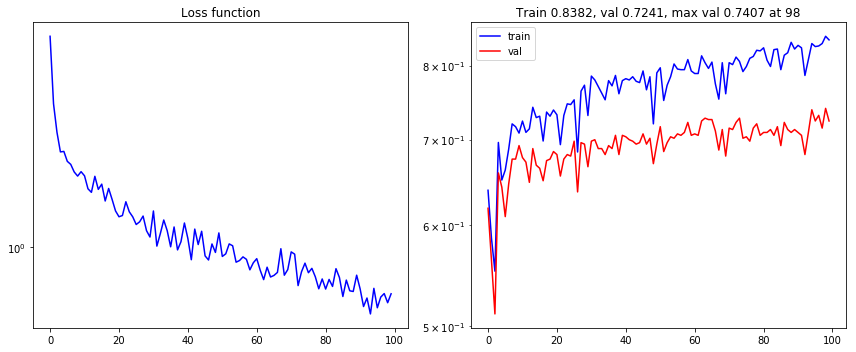


100%|██████████| 100/100 [38:09<00:00, 22.94s/it]


In [0]:
set_random_seeds(device=device)
train(model, torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), epochs_n= 100,
      criterion= nn.CrossEntropyLoss(weight = torch.tensor([1634/579.0, 1634/412.0, 1634/583.0, 1634/234.0]).cuda()), 
      device= device)

In [0]:
for dct in train_loader:
            x = dct['sensors']
            f = dct['features']
            y = dct['y']
            x = x.to(device)  ## <---
            f = f.to(device)
            y = y.to(device) ## <---
            prediction = model(x, f).argmax(dim = -1)

            print((prediction.view(-1) == y).sum(), (prediction.view(-1) != y).sum())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(23, device='cuda:0') tensor(9, device='cuda:0')
tensor(24, device='cuda:0') tensor(8, device='cuda:0')
tensor(22, device='cuda:0') tensor(10, device='cuda:0')
tensor(26, device='cuda:0') tensor(6, device='cuda:0')
tensor(26, device='cuda:0') tensor(6, device='cuda:0')
tensor(30, device='cuda:0') tensor(2, device='cuda:0')
tensor(29, device='cuda:0') tensor(3, device='cuda:0')
tensor(24, device='cuda:0') tensor(8, device='cuda:0')
tensor(24, device='cuda:0') tensor(8, device='cuda:0')
tensor(27, device='cuda:0') tensor(5, device='cuda:0')
tensor(26, device='cuda:0') tensor(6, device='cuda:0')
tensor(25, device='cuda:0') tensor(7, device='cuda:0')
tensor(27, device='cuda:0') tensor(5, device='cuda:0')
tensor(24, device='cuda:0') tensor(8, device='cuda:0')
tensor(28, device='cuda:0') tensor(4, device='cuda:0')
tensor(26, device='cuda:0') tensor(6, device='cuda:0')
tensor(24, device='cuda:0') tensor(8, device='cuda:0')
tensor(25, device='cuda:0') tensor(7, device='cuda:0')
tensor(26

In [0]:
!ls

data.pkl
features.pkl
parkinson_binary_feat_and_time_series.pth
parkinson_binary_time_series.pth
parkinson_multiclass_feat_and_time_series.pth


In [0]:
class_distr = np.zeros((4,4))
for dct in train_loader:
      x = dct['sensors']
      f = dct['features']
      y = dct['y']
      x = x.to(device)  ## <---
      f = f.to(device)
      y = y.cpu().detach().numpy() ## <---
      prediction = model(x, f).argmax(dim = -1).view(-1).cpu().detach().numpy()
      for i in range(len(y)):
          class_distr[y[i]][prediction[i]] += 1 
          
          
          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


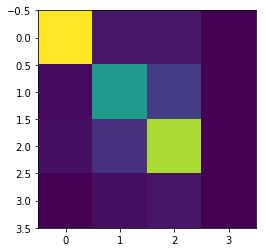

In [0]:
plt.imshow(class_distr)